In [3]:
from sklearn.neighbors import BallTree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [7]:
def get_nearest_neighbors(gdf_obs, gdf_cand = None, k_neighbors=5):
    if gdf_cand is None:
        gdf_cand = gdf_obs 
    src_points = [(x,y) for x,y in zip(gdf_obs.geometry.x , gdf_obs.geometry.y)]
    candidates =  [(x,y) for x,y in zip(gdf_cand.geometry.x , gdf_cand.geometry.y)]
    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')
    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors+1)
    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()
    closest_gdfs = []
    for k in np.arange(k_neighbors):
        gdf_new = gdf_cand.iloc[indices[k+1]].reset_index()
        del gdf_new['index']
        gdf_new = gdf_new.add_suffix(f'_{k+1}')
        closest_gdfs.append(gdf_new)      
    closest_gdfs.insert(0,gdf_obs)    
    gdf_final = pd.concat(closest_gdfs,axis=1)
    return gdf_final

def rfsi(data=None,model=None, 
k_neighbors=5, vname = '', ntrees = 150, bound_grid = None,
grid_res = 10, grid_geom = 'Point',
seed = None, folds = 5):
    # Name of the column with the data
    target = vname
    if isinstance(data,gpd.GeoDataFrame):
        # Setting the Random Forest model
        random_forest_model = RandomForestRegressor(n_estimators=ntrees, random_state=seed)
        if isinstance(k_neighbors, list):
            print("Searching for the optimal parameter...")
            # Getting knn nearest neighbors
            gdf_nn = get_nearest_neighbors(gdf_obs=data,k_neighbors=max(k_neighbors))
            xv = pd.DataFrame(columns=['knn','rmse'])
            for j in k_neighbors:
                knn = j
                # Automatically generate feature name based on target name and k value
                features = [f'{target}_{i}' for i in range(1, knn + 1)]
                X = gdf_nn[features]
                y = gdf_nn[target]
                # Setting the folds for cross validation
                kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
                # Perform cross-validation and obtain predictions and actual values
                predictions = cross_val_predict(random_forest_model, X, y, cv=kf)
                # Creating a DataFrame with the "observed" and "predicted" columns
                residuals = pd.DataFrame({'observed': y, 'predicted': predictions})
                # Calculating the RMSE using the observed and predicted values ​​in the DataFrame
                rmse = np.sqrt(mean_squared_error(residuals['observed'], residuals['predicted']))
                # Record the value of rmse
                print("Number of nearest neighbors tested: ", knn, " - Resulting rmse: ", round(rmse,3))
                xv.loc[len(xv)] = [knn, rmse]     
            # Filtering the lowest rmse value
            min_rmse = xv.loc[xv['rmse'].idxmin()]
            # Obtaining the optimal number of neighbors
            knn = int(min_rmse['knn'])
            rmse = min_rmse['rmse']
            print("Optimal number of nearest neighbors: ", knn, " - rmse: ", round(rmse,3))
        elif isinstance(k_neighbors, int):
            knn = k_neighbors
            # Getting the knn nearest neighbors
            gdf_nn = get_nearest_neighbors(gdf_obs=data,k_neighbors=knn)
            residuals = pd.DataFrame({'observed': [], 'predicted': []})
        else:
            return "Data type not supported for k_neighbors"
        print("Obtaining the prediction model...")
        # Automatically generate feature name based on target name and k value
        features = [f'{target}_{i}' for i in range(1, knn + 1)]
        X = gdf_nn[features]
        y = gdf_nn[target]
        # Training the model using all the data
        random_forest_model.fit(X, y)
    elif isinstance(model,RandomForestRegressor):
        random_forest_model=model
    else:
        return "You must specify data to model or a model itself"
    if isinstance(bound_grid, gpd.GeoDataFrame):
        print("Predicting over the grid...")
        # Creating a grid of points with the resolution specified in grid_res within the polygon area
        minx, miny, maxx, maxy = bound_grid.total_bounds
        x_coords = range(int(minx), int(maxx), grid_res)
        y_coords = range(int(miny), int(maxy), grid_res)       
        # Create an empty list to store the grid points
        grid_points = []
        # Iterate over each coordinate in the grid
        for x in x_coords:
            for y in y_coords:
                # Create a point with the current coordinates
                point = Point(x + grid_res/2, y + grid_res/2)  # Use the center point of each cell                
                # Add the point to the list
                grid_points.append(point)
        # Create a GeoDataFrame from the list of points
        grid = gpd.GeoDataFrame(geometry=grid_points, crs=bound_grid.crs)
        # Intersect the grid with the polygon to eliminate cells that are outside the perimeter
        intersect_grid = gpd.overlay(grid, bound_grid, how='intersection')
        # Get the nearest neighbors of each cell
        grid = get_nearest_neighbors(gdf_obs=intersect_grid, gdf_cand=data, k_neighbors=knn)
        # Apply the Random Forest model to predict the values ​​on the grid
        predict_grid = random_forest_model.predict(grid[features])
        # Adds the predictions as a new column in the grid's GeoDataFrame
        intersect_grid['pred'] = predict_grid
        # If required, transform the Point grid to a Polygon grid
        if grid_geom=='Polygon':
            grid_poly=[]
            for punto in intersect_grid['geometry']:
                x, y = punto.x, punto.y
                grid_poly.append(Polygon([(x-grid_res/2, y-grid_res/2), (x+grid_res/2, y-grid_res/2), (x+grid_res/2, y+grid_res/2), (x-grid_res/2, y+grid_res/2)]))
            intersect_grid = gpd.GeoDataFrame({'geometry': grid_poly, 'pred': intersect_grid['pred']})
    else:
        intersect_grid = gpd.GeoDataFrame(columns=['geometry','pred'], geometry='geometry')
    # Returns the trained model, the residuals and the interpolated grid
    return random_forest_model, intersect_grid, residuals

def plot_predictions(predictions,vname = 'pred',
colors = [],breaks = [],
plot_size=[10,10], show_plot=True,plot_title = 'Predictions over the grid',
legend_title='Legend',legend=True):
    if len(colors)+1!=len(breaks):
        return "You must specify a color for each interval"
    elif len(plot_size)!=2 or not isinstance(plot_size,list):
        return "The size of the graph must be specified in a list of two elements"
    elif not isinstance(predictions,gpd.GeoDataFrame):
        return "The grid with the predictions is expected to be a GeoDataFrame"
    elif not vname in predictions.columns:
        return "The name of the variable to plot is not found in the grid"    
    # Create the custom color scale
    cmap = mcolors.ListedColormap(colors)
    # Define color boundaries
    norm = mcolors.BoundaryNorm(breaks, cmap.N)
    # Create a figure and its axes
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the grid with predictions
    predictions.plot(ax=ax, column=vname, cmap=cmap, norm=norm,legend=False)
    # Add plot title
    ax.set_title(plot_title)
    # Removing the x y axis from plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if legend:
        # Create a custom legend
        legend_elements = []
        for i in range(1,len(breaks)):
            legend_elements.append(Line2D([0], [0], marker='s', color='w', label=f'{breaks[i-1]}-{breaks[i]}', markerfacecolor=colors[i-1], markersize=10))
        # Add the legend to plot
        ax.legend(handles=legend_elements, title=legend_title)
    # Show the plot
    if show_plot:
        plt.show()
    # Return the figure and plot
    return fig, ax

In [8]:
obs = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_04")
bound = gpd.read_file(filename="Data/F05_boundary.gpkg")
#knn = [5,10,15,20,25,30,35]
knn = [5,10,15]
model, predictions, resid= rfsi(data=obs,k_neighbors=knn,vname='EC30',bound_grid=bound,grid_geom='Polygon',grid_res=10,seed=701408733)
print(predictions['pred'].min(),predictions['pred'].max())

Searching for the optimal parameter...
Number of nearest neighbors tested:  5  - Resulting rmse:  2.063
Number of nearest neighbors tested:  10  - Resulting rmse:  2.042
Number of nearest neighbors tested:  15  - Resulting rmse:  2.057
Optimal number of nearest neighbors:  10  - rmse:  2.042
Obtaining the prediction model...
Predicting over the grid...
9.065999999999985 49.274666666666675


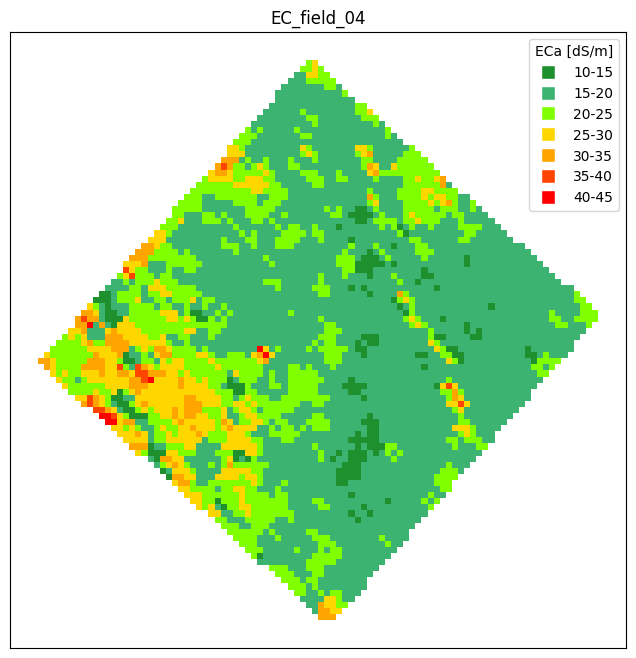

In [10]:
colors = [
    '#1E902D',
    '#3CB371',
    '#7FFF00',
    '#FFD700',
    '#FFA500',
    '#FF4500',
    '#FF0000'
]
breaks = [10, 15, 20, 25, 30, 35, 40, 45]
plot_predictions(predictions=predictions,colors=colors,breaks=breaks,plot_title='EC_field_04',legend_title='ECa [dS/m]')

Obtaining the prediction model...
Predicting over the grid...


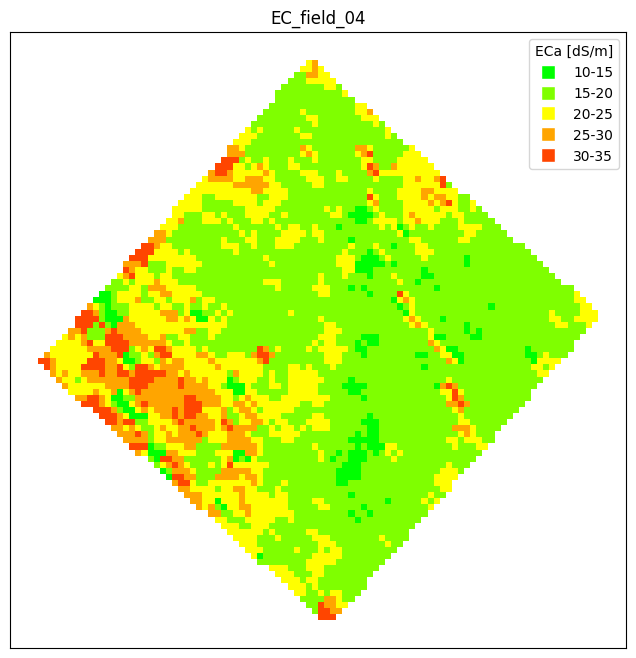

In [11]:
obs = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_04")
bound = gpd.read_file(filename="Data/F05_boundary.gpkg")
knn = 10
model, predictions, resid= rfsi(data=obs,k_neighbors=knn,vname='EC30',bound_grid=bound,grid_geom='Polygon',grid_res=10,seed=701408733)
colors = ['#00FF00', '#7FFF00', '#FFFF00', '#FFA500', '#FF4500']
breaks = [10, 15, 20, 25, 30, 35]
plot_predictions(predictions=predictions,colors=colors,breaks=breaks,plot_title='EC_field_04',legend_title='ECa [dS/m]')